### Load the raster

In [1]:
import os
data_folder = "Data"
cuprite_nevada_folder = "Cuprite Nevada"


filename = "ENMAP01-____L2A-DT0000025905_20230707T192008Z_001_V010303_20230922T131734Z-SPECTRAL_IMAGE.TIF"

raster_path = os.path.join(data_folder, cuprite_nevada_folder, filename)

In [2]:
from Raster import Raster

raster = Raster(path=raster_path)

### Clip to ROI

In [3]:
import geopandas as gpd
from vector_utils import clip_raster
import utils

polygon_path = os.path.join(data_folder, cuprite_nevada_folder, "ROI.geojson")

polygon = gpd.read_file(polygon_path)
raster = clip_raster(raster, polygon)

Reprojecting GeoDataFrame from EPSG:4326 to EPSG:32611


### Preprocess

Handle missing bands, rescale by gain and offset, convert units to um, and concentrate by removing bands.

In [4]:
raster = utils.preprocess(raster)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Get a target mineral reference spectrum

In [5]:
from Spectrum import Spectrum

In [6]:
ref_spectrum = Spectrum(mineral_name = "kaolinite")

In [7]:
ref_spectrum.preprocess(desired_wavelengths=raster.wavelength)

Text(0, 0.5, 'Reflectance')

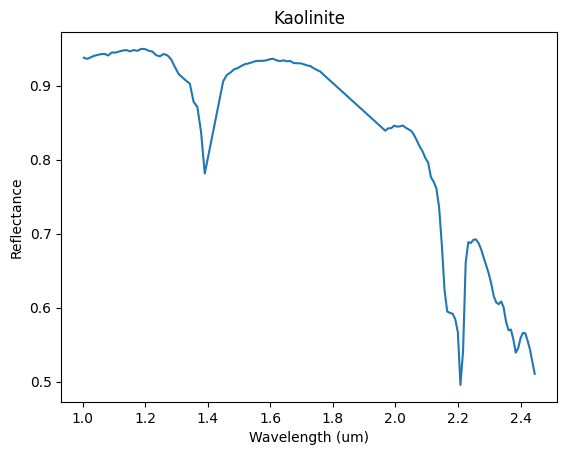

In [8]:
import matplotlib.pyplot as plt

plt.plot(ref_spectrum.wavelength, ref_spectrum.reflectance)
plt.title("Kaolinite")
plt.xlabel("Wavelength (um)")
plt.ylabel("Reflectance")

### Mineral mapping

In [9]:
import numpy as np

sam_score = utils.spectralMatch(raster, ref_spectrum, method="sam")
threshold = 0.07
masked_sam_score = np.ma.masked_greater(sam_score, threshold)

/Users/pookie/Desktop/Geospatial_AI/Remote-Sensing-for-Mineral-Exploration-Demo/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpectralAngleMapper` will save all targets and predictions in the buffer when using`reduction=None` or `reduction='none'. For large datasets, this may lead to a large memory footprint.
  warnings.warn(*args, **kwargs)


Reprojecting GeoDataFrame from EPSG:4326 to EPSG:32611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.492459555799287..1.0].


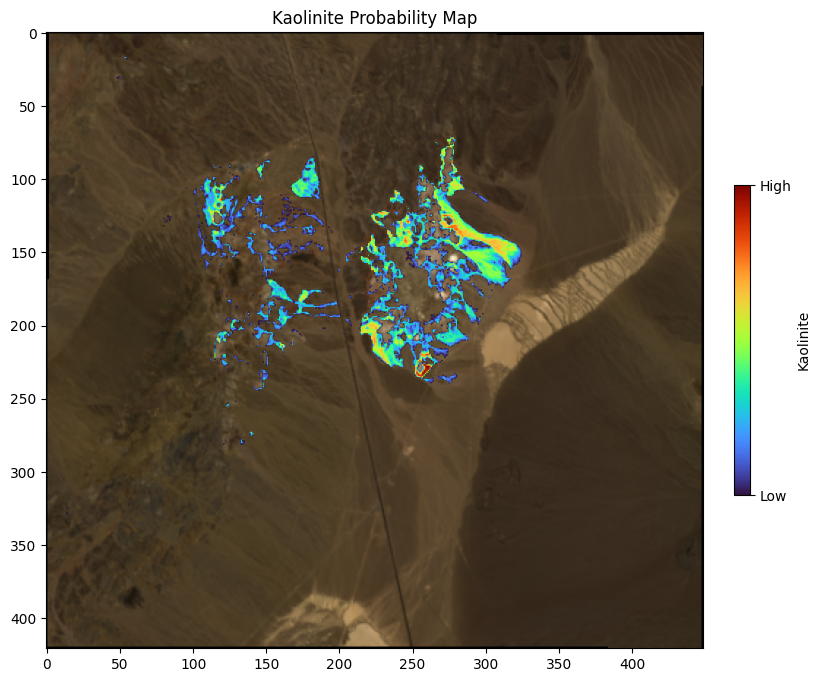

In [10]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Plot the results
# RGB from the hyperspectral image
raster_for_rgb = Raster(path=raster_path)
raster_for_rgb = clip_raster(raster_for_rgb, polygon)

rgb_indices = utils.get_rgb_indices(raster_for_rgb)

red = raster_for_rgb.datacube[rgb_indices[0], :, :]
green = raster_for_rgb.datacube[rgb_indices[1], :, :]
blue = raster_for_rgb.datacube[rgb_indices[2], :, :]

raster_for_rgb.datacube = np.stack([red, green, blue])

# Normalize the RGB datacube
raster_data = raster_for_rgb.datacube
raster_data = raster_data.astype(float)  # Convert to float for normalization
raster_data /= raster_data.max()  # Normalize to 0-1

# Rearrange the axes to (height, width, channels)
rgb_image = np.transpose(raster_data, (1, 2, 0))

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image)

sam_im = ax.imshow(masked_sam_score, cmap='turbo_r')

# Create a colorbar with a title and labels
norm = Normalize(vmin=0, vmax=1)
mapper = ScalarMappable(norm=norm, cmap='turbo')
# colorbar = plt.colorbar(mapper, fraction=0.02, pad=0.04)
colorbar = plt.colorbar(mapper, ax=ax, fraction=0.02, pad=0.04)

colorbar.set_label('Kaolinite')
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['Low', 'High'])

ax.set_title('Kaolinite Probability Map')

fig.savefig('map.svg', format='svg')

plt.show()

### Inspect a ROI

Look at the highest mineral match (warmer color), at the southernmost detection (use row and columns).
There are good indicative absorptions at 2.16 and 2.20 um, and two smaller absorptions at 2.31 and 2.38 um of Kaolinite mineral!

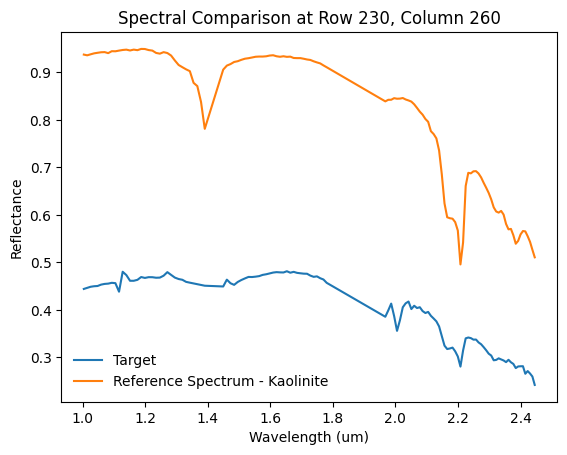

In [11]:
row, col = 230, 260

target_spec = raster.datacube[:, row, col]

fig, ax = plt.subplots()
ax.plot(raster.wavelength, target_spec, label="Target")
ax.plot(raster.wavelength, ref_spectrum.reflectance, label="Reference Spectrum - Kaolinite")

ax.legend(frameon=False)
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Reflectance")
ax.set_title(f"Spectral Comparison at Row {row}, Column {col}")

fig.savefig('spectrum.svg', format='svg')

plt.show()

In [12]:
pip list

Package                   Version
------------------------- --------------
affine                    2.4.0
anyio                     4.9.0
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
click                     8.1.8
click-plugins             1.1.1
cligj                     0.7.2
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.13
decorator                 5.2.1
defusedxml                0.7.1
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.18.0
fonttools                 4.57.0
fqdn          